## Import my dataset from drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd '/content/gdrive/My Drive/UnB/TCC-1/TCC-1-dataset'

/content/gdrive/My Drive/UnB/TCC-1/TCC-1-dataset


In [3]:
!ls

dataset-split	      restnet_model152_1.pt
dataset-split.tar.xz  skin_lesion_to_name.json


# Import all important libs

In [0]:
# Imports here
import torch
import json
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler
from PIL import Image
%matplotlib inline

### Chck if there is any GPU avalible for training

In [5]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Setting all important dirs for this phase

In [0]:
# Dataset dir base
dataset_dir = '/content/gdrive/My Drive/UnB/TCC-1/TCC-1-dataset/dataset-split'
test_dir = dataset_dir + '/dataset-test'

# Const to save test infos in csv
CSV_TEST_DIR='/content/gdrive/My Drive/UnB/TCC-1/TCC-1-dataset/dataset-split'

# Model dir 
pre_model_dir='/content/gdrive/My Drive/UnB/TCC-1/TCC-1-dataset/restnet_model152_1.pt'

# Image test from test_dir
image_test_dir='/content/gdrive/My Drive/UnB/TCC-1/TCC-1-dataset/dataset-split/test/basal-cell-carcinoma/basal-cell-carcinoma_original_3210.jpg_6e88dd4a-6a26-4c3c-a21d-8c92f9cd35f8.jpg'

batch_size=1

In [0]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean,
                                        std)
                                      ])

# TODO: Load the datasets with ImageFolder
test_data = datasets.ImageFolder(test_dir,transform = test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

## Loading restnet152 pretrainer model and set fullyconnected layer to 12

In [0]:
model_name='resnet'
num_classes = 12
feature_extract = False

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

## Loading pre-trained model from google colab

In [11]:
if train_on_gpu:
    state = torch.load(pre_model_dir)
else:
    state = torch.load(pre_model_dir, map_location='cpu')

# Loading weights in restnet architecture
model_ft.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [0]:
# Future implementation
# def load_model(checkpoint_path):
#     chpt = torch.load(checkpoint_path)
    
#     if chpt['arch'] == 'restnet152':
#         model = models.vgg19(pretrained=True)
#         for param in model.parameters():
#             param.requires_grad = False
    
#     else:
#         print("Sorry base architecture note recognized")

    
#     model.class_to_idx = chpt['class_to_idx']
    
#     # Create the classifier
#     model.fc = nn.Linear(2048, 12)
    
#     model.load_state_dict(chpt['state_dict'])
    
#     return model

In [0]:
# Load the model base on path
#model = load_model('classifier.pth')

## Built-in functions to help

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Resize where shortest side is 256px, keeping aspect ratio
    minside = 256
    img = Image.open(image)
    imagex, imagey = img.size
    aspect = float(imagex)/float(imagey)
    
    if imagex <= imagey:
      width = 256
      height = int(width/aspect)
    else:
      height = 256
      width = int(height*aspect)
   
    img = img.resize((width,height),Image.ANTIALIAS)
    
    # Crop out center 224 x 224
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))
    
    # Convert image to numpy array
    np_image = np.array(img)
    np_image = np_image/255
    
    # Normalize image
    np_image -= [0.485, 0.456, 0.406]
    np_image /= [0.229, 0.224, 0.225]
    
    # Transpose array:
    result = np_image.transpose(-1,0,1)
    
    return result

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

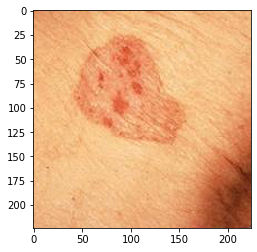

In [16]:
result = process_image(image_test_dir)
res = torch.from_numpy(result)
imshow(res)

## Function to make single predictions base on top5 most close match

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.eval()
    image = process_image(image_path)
    image = torch.from_numpy(image)

    if train_on_gpu:
      model.cuda()
      image = image.cuda()
    image = image.float().unsqueeze(0)
    out = model.forward(image)
    logps = F.log_softmax(out)
    ps = torch.exp(logps)
    probs, classes = ps.topk(topk, dim=1)

    if train_on_gpu:
      probs = list(probs.squeeze(0).cpu().detach().numpy())
      classes = list(classes.squeeze(0).cpu().detach().numpy())

    else:
      probs = list(probs.squeeze(0).detach().numpy())
      classes = list(classes.squeeze(0).detach().numpy())
    idx_class_mapping = dict((v,k) for k,v in test_data.class_to_idx.items())
    classes = list(map(lambda x: idx_class_mapping[x], classes))

    return probs, classes


In [18]:
probs, classes = predict(image_test_dir, model_ft)
print(probs)
print(classes)

[0.56770194, 0.41477022, 0.014697589, 0.0013990226, 0.0007185375]
['intraepithelial-carcinoma', 'basal-cell-carcinoma', 'lentigo', 'malignant-melanoma', 'squamous-cell-carcinoma']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


## Load map number to name dict

In [0]:
with open('/content/gdrive/My Drive/UnB/TCC-1/TCC-1-dataset/skin_lesion_to_name.json', 'r') as f:
    skin_lesion_to_name = json.load(f)

In [20]:
skin_lesion_to_name.keys()

dict_keys(['dermatofibroma', 'malignant-melanoma', 'squamous-cell-carcinoma', 'pyogenic-granuloma', 'lentigo', 'actinic-keratosis', 'intraepithelial-carcinoma', 'melanocytic-nevus', 'seborrheic-keratosis', 'wart', 'basal-cell-carcinoma', 'hemangioma'])

In [21]:
list(skin_lesion_to_name)

['dermatofibroma',
 'malignant-melanoma',
 'squamous-cell-carcinoma',
 'pyogenic-granuloma',
 'lentigo',
 'actinic-keratosis',
 'intraepithelial-carcinoma',
 'melanocytic-nevus',
 'seborrheic-keratosis',
 'wart',
 'basal-cell-carcinoma',
 'hemangioma']

In [0]:
def plot_bar(image_path, model):
  result = process_image(image_path)
  res = torch.from_numpy(result)
  fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
  ax1 = imshow(res, ax1)
  probs, classes = predict(image_path,model)
  ax2.barh(np.arange(len(probs)), probs)
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(len(probs)))
  v = list(skin_lesion_to_name.keys())
  # classes = list(map(lambda x: skin_lesion_to_name[x], classes))
  ax2.set_yticklabels(classes, size='small');
  ax2.set_title('Class Probability')
  ax2.set_xlim(0, 1.1)
  plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


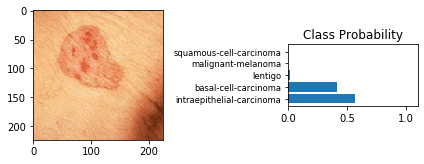

In [23]:
plot_bar(image_test_dir ,model_ft)

## Test routine for test_dir

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
import csv

def test(model, testloader):

  model.eval()
  test_loss = 0.0

  class_correct = list(0. for i in range(12))
  class_total = list(0. for i in range(12))
    
  y = []
  y_score = []

  for data, target in testloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    
    # forward pass:
    output = model(data)
    
    # calculate batch loss
    loss = criterion(output, target)
    
    # update validation loss
    test_loss += loss.item()*data.size(0)

    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    
    # Return for future ROC Avaliation
    # y_score.append(output.cpu())
    # y.append(target.cpu().numpy())
    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate validation accuracy for each object class
    for i in range(target.data.size()[0]):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
    # Write in csv training infos
    # row = [y_score, y, test_loss, target]
    # with open(CSV_TEST_DIR + '/teste_phase.csv', 'a') as csvFile:
    #  writer = csv.writer(csvFile)
    #  writer.writerow(row)
                                                            
    # csvFile.close()

  # calculate average losses
  test_loss = test_loss / len(testloader.dataset)

  # print training/validation statistics 
  print('Test Loss: {:.6f}'.format(test_loss))

  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
  
  return class_total, class_correct, test_loss, y_score, y

In [0]:
# Run just in google colab
# class_total, class_correct, test_loss, y_score, y = test(model,testloader)

In [0]:
def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model_ft, 'cuda', testloader)

### Moreover, ROC and AUC metrics to avalute de model

In [29]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


print('Confusion matrix:')
print(confusion_matrix(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))

Confusion matrix:
[[12  1  0  0  2  1  0  0  0  1  4  0]
 [ 1 67  3  0  0  3  0  1  2  0  9  1]
 [ 0  1 18  1  0  0  0  0  0  1  1  0]
 [ 0  2  0 14  0  0  1  0  1  0  0  0]
 [ 1  0  0  0 14  0  1  0  0  1  0  0]
 [ 0  3  0  0  1 11  0  0  0  2  0  0]
 [ 0  0  0  0  1  3 60  2  0  3  0  1]
 [ 0  0  1  0  0  0  1 44  1  4  0  0]
 [ 0  1  0  0  0  0  0  0 10  0  0  0]
 [ 0  1  0  0  1  4  3  3  0 57  1  1]
 [ 6 10  1  0  4  0  0  0  0  2 19  1]
 [ 0  0  0  0  0  1  0  0  1  0  1  5]]
F1 score: 0.759174
Accuracy score: 0.759174


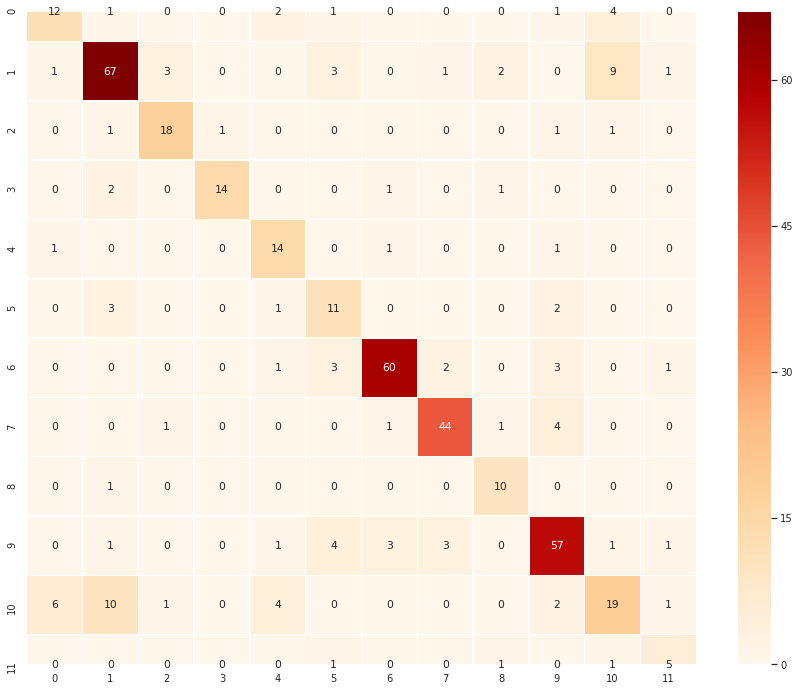

In [30]:
array= confusion_matrix(actuals, predictions)
df_cm = pd.DataFrame(array)
plt.figure(figsize = (15,12))
sn.set(font_scale=0.9)
sn.heatmap(df_cm, annot=True,linewidths=.5, cmap="OrRd")

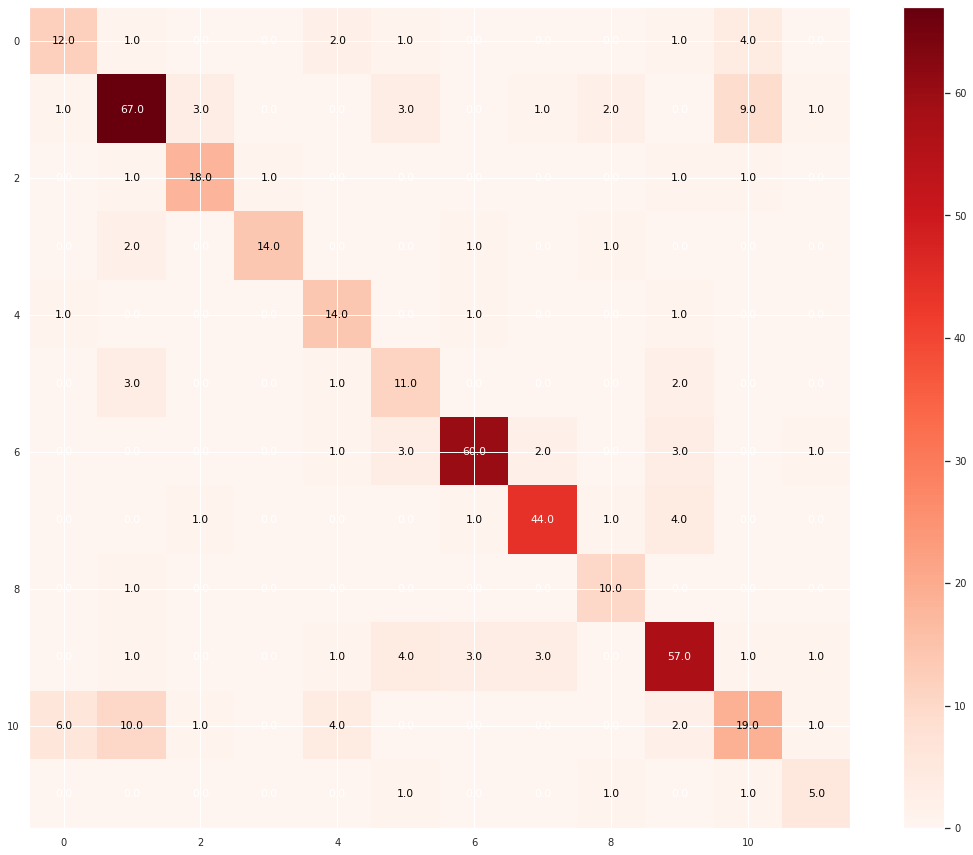

In [31]:
nb_classes = 12   
confusion_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
  for i, (inputs, target) in enumerate(testloader):
    inputs = inputs.to('cuda')
    target = target.to('cuda')

    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)

    for t, p in zip(target.view(-1), preds.view(-1)):
      confusion_matrix[t.long(), p.long()] += 1

num_classes = 12
class_names = ['dermatofibroma', 'malignant-melanoma', 'squamous-cell-carcinoma', 'pyogenic-granuloma', 'lentigo',
 'actinic-keratosis', 'intraepithelial-carcinoma', 'melanocytic-nevus', 'seborrheic-keratosis', 'wart',
 'basal-cell-carcinoma', 'hemangioma']              

plt.figure(figsize = (15,12))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Reds, )

tick_marks = np.arange(num_classes)
classNames = class_names

thresh = confusion_matrix.max() / 2.
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix[i, j]),
                ha="center", va="center",
                color="white" if  confusion_matrix[i, j] == 0 or confusion_matrix[i, j] > thresh else "black") 
plt.tight_layout()
plt.colorbar()
plt.show()   

## ROC for intraepithelial-carcinoma

In [0]:
def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction) == torch.from_numpy(np.array(which_class)))
            probabilities.extend(np.exp(output[:, torch.from_numpy(np.array(which_class))].cpu()))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

In [0]:
# 6: 'intraepithelial-carcinoma' 
which_class = 6
actuals, class_probabilities = test_class_probabilities(model_ft, 'cuda', testloader, which_class)

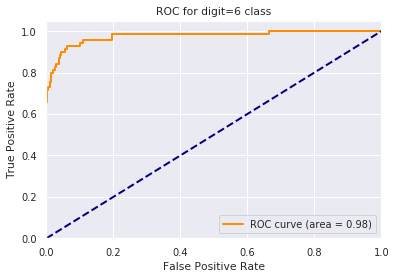

In [35]:
fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for digit=%d class' % which_class)
plt.legend(loc="lower right")
plt.show()

In [0]:
# 9: 'Wart' 
which_class = 9
actuals, class_probabilities = test_class_probabilities(model_ft, 'cuda', testloader, which_class)

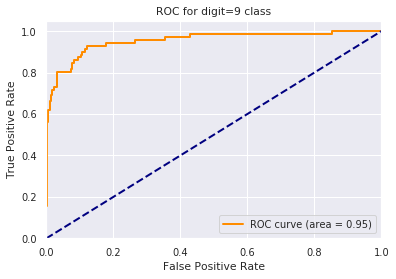

In [37]:
fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for digit=%d class' % which_class)
plt.legend(loc="lower right")
plt.show()

In [0]:
# 11: 'hemangioma' 
which_class = 11
actuals, class_probabilities = test_class_probabilities(model_ft, 'cuda', testloader, which_class)

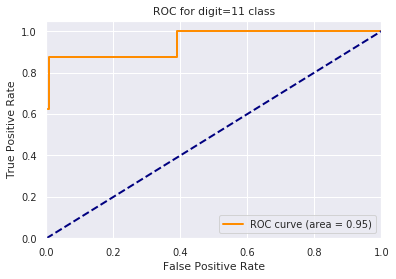

In [39]:
fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for digit=%d class' % which_class)
plt.legend(loc="lower right")
plt.show()

In [0]:
# 2: 
which_class = 2
actuals, class_probabilities = test_class_probabilities(model_ft, 'cuda', testloader, which_class)

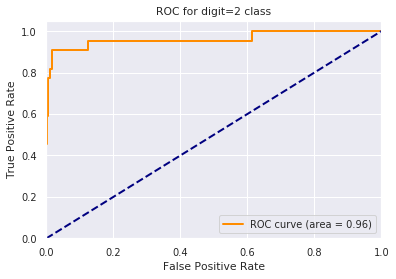

In [42]:
fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for digit=%d class' % which_class)
plt.legend(loc="lower right")
plt.show()